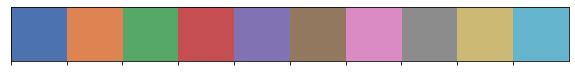

In [1]:
%matplotlib inline

import lsqfit
from improved_model_averaging import *
from improved_model_averaging.test_model_vary import test_vary_poly

In [2]:
p0_test_quad = {
    'a0': 1.80,
    'a1': -0.53,
    'a2': 0.31,
}
Nt = 16
noise_params = {
    'frac_noise_amp': 1.0,
    'noise_floor_amp': 0.0,
    'noise_samples': 160,
#     'noise_samples': 5120,
}
obs_name='a0'

def quad_model(x,p):
    return poly_model_lsqfit(x,p,Nt,m=2)

## Set seed for consistency of outcome
np.random.seed(96737)  # Fig 1 and 2; Table II

In [3]:
test_data = gen_synth_data(
    np.arange(1,Nt),
    p0_test_quad, 
    quad_model,
    **noise_params)

In [4]:
IC_list = ['AIC', 'BAIC', 'BPIC', 'PPIC']
test_res = test_vary_poly(test_data, IC_list=IC_list, mu_max=5, mu_min=0, Nt=Nt, obs_name=obs_name)

for IC in IC_list:
    print(IC + f": a_0 = {test_res['obs_avg_IC'][IC]}")

AIC: a_0 = 1.88(14)
BAIC: a_0 = 1.89(14)
BPIC: a_0 = 1.85(12)
PPIC: a_0 = 1.88(14)


In [5]:
## Table II

import pandas as pd

test_res_df = pd.DataFrame({ 'fits': test_res['fits']})
for pn in ('a0','a1', 'a2', 'a3', 'a4', 'a5'):
    test_res_df[pn] = test_res_df['fits'].apply(lambda f: f.p.get(pn))

test_res_df['chi2'] = test_res_df['fits'].apply(lambda f: f.chi2)
tdf = test_res_df.drop('fits', axis=1).rename(columns={'obs': 'a0'})
tdf['chi2'] = tdf['chi2'].round(2)

tdf['chi2tilde'] = (np.array(test_res['IC']['AIC'])-np.array(test_res['IC']['BAIC'])).round(2)
tdf['chi2hat'] = (tdf['chi2']-tdf['chi2tilde']).round(2)

tdf['Qs'] = test_res['Qs']
tdf['Qs'] = tdf['Qs'].round(2)

for IC in IC_list:
    tdf[IC] = np.array(test_res['IC'][IC])
    tdf[IC] = tdf[IC].round(2)
    tdf['p_' + IC] = test_res['prob'][IC]
    tdf['p_' + IC] /= np.sum(tdf['p_' + IC])
    tdf['p_' + IC] = tdf['p_' + IC].round(2)

tdf  # Table II

,a0,a1,a2,a3,a4,a5,chi2,chi2tilde,chi2hat,Qs,AIC,p_AIC,BAIC,p_BAIC,BPIC,p_BPIC,PPIC,p_PPIC
0,1.587(32),None,None,None,None,None,28.85,0.00,28.85,0.02,30.85,0.00,30.85,0.00,31.85,0.00,30.85,0.00
1,1.803(67),-0.41(11),None,None,None,None,15.20,0.03,15.17,0.44,19.20,0.45,19.17,0.43,21.17,0.61,19.18,0.43
2,1.89(11),-0.88(50),0.44(46),None,None,None,14.28,0.05,14.23,0.50,20.28,0.26,20.23,0.25,23.23,0.22,20.24,0.25
3,2.01(16),-2.2(1.3),3.6(3.0),-2.1(2.0),None,None,13.16,0.28,12.88,0.59,21.16,0.17,20.88,0.18,24.73,0.10,20.89,0.18
4,1.98(17),-1.6(1.5),0.4(5.0),3.4(7.1),-3.0(3.7),None,12.52,0.29,12.23,0.64,22.52,0.08,22.22,0.09,26.30,0.05,22.23,0.09
5,1.94(18),-1.0(1.8),-1.0(5.5),2.9(7.2),1.5(7.7),-3.1(4.7),12.08,0.29,11.79,0.67,24.08,0.04,23.79,0.04,28.13,0.02,23.80,0.04


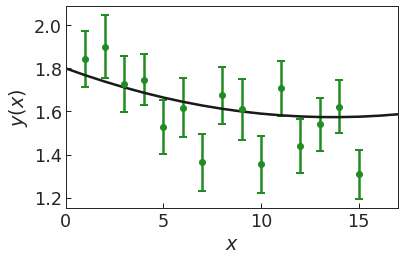

In [6]:
plot_gvcorr(test_res['data']['y'], x=np.arange(1,Nt), color='forestgreen')

TF = test_res['fits'][2]
plot_gvcorr(TF.fcn(np.arange(0,18), p0_test_quad), 
            x=np.arange(0,18), color='k', fill=True)

plt.xlabel('$x$')
plt.ylabel('$y(x)$')
plt.xlim(0,17)

plt.tight_layout()

## Uncomment to save figure to disk
# plt.savefig('plots/poly/fixed_N_data.pdf', bbox_inches = "tight")

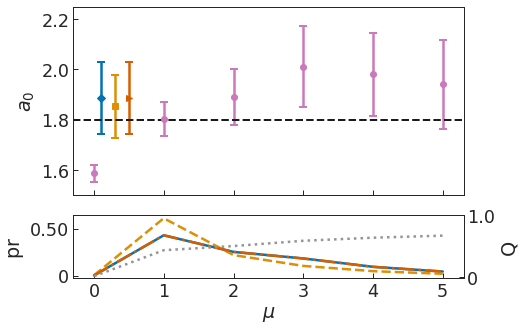

In [7]:
## Figure 1

plot_MA_result(test_res, IC_list=IC_list[1:], target_value=p0_test_quad[obs_name], show_IC_ratios=False, ylim=[1.5,2.25])

## Uncomment to save figure to disk
# plt.savefig('plots/poly/fixed_N_160_results.pdf', bbox_inches = "tight")  # Fig 1A
# plt.savefig('plots/poly/fixed_N_5120_results.pdf', bbox_inches = "tight")  # Fig 1B

In [8]:
## Scaling w/number of samples

Nsamp_array = np.array([40, 80, 160, 320, 640, 1280])
Nsamp_max = Nsamp_array[-1]

noise_params['noise_samples'] = Nsamp_max
scale_data = gen_synth_data(
    np.arange(1,Nt), 
    p0_test_quad, 
    quad_model,
    **noise_params)

IC_list = ['BAIC', 'BPIC', 'PPIC']
fixed_list = ['quad']
fixed_mu = {'quad': 2,
           }

obs_est_vs_Nsamp={}
for est in IC_list + fixed_list:
    obs_est_vs_Nsamp.update({est: []})

for Nsamp in Nsamp_array:
    test_data_scale = cut_synth_data_Nsamp(scale_data, Nsamp)
    test_res_scale = test_vary_poly(test_data_scale, mu_max=5, mu_min=0, Nt=Nt, obs_name=obs_name)
    
    for IC in IC_list:
        obs_est_vs_Nsamp[IC].append(test_res_scale['obs_avg_IC'][IC])
    for fixed in fixed_list:
        obs_est_vs_Nsamp[fixed].append(test_res_scale['obs'][fixed_mu[fixed]])

<AxesSubplot:xlabel='$\\log(N)$', ylabel='$a_0$'>

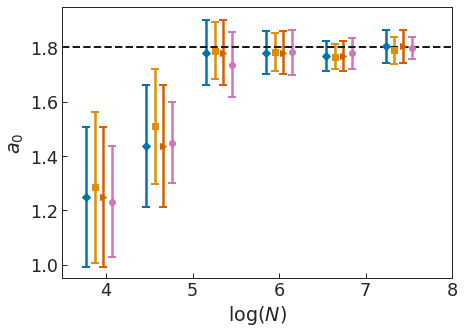

In [9]:
## Figure 2

plot_MA_result_scaling(obs_est_vs_Nsamp, Nsamp_array, IC_list=IC_list, fixed_list=fixed_list, target_value=p0_test_quad[obs_name], ylim=[0.95,1.95])

## Uncomment to save figure to disk
# plt.savefig('plots/poly/N_scaling.pdf', bbox_inches = "tight")  # Fig 2